#用岭回归弥补线性回归的不足

本主题将介绍岭回归。和线性回归不同，它引入了正则化参数来“缩减”相关系数。当数据集中存在共线因素时，岭回归会很有用。

<!-- TEASER_END -->

##Getting ready

让我们加载一个不满秩（low effective rank）数据集来比较岭回归和线性回归。秩是矩阵线性无关组的数量，满秩是指一个$m \times n$矩阵中行向量或列向量中现行无关组的数量等于$min(m,n)$。

##How to do it...

首先我们用`make_regression`建一个有3个自变量的数据集，但是其秩为2，因此3个自变量中有两个自变量存在相关性。

In [1]:
from sklearn.datasets import make_regression
reg_data, reg_target = make_regression(n_samples=2000, n_features=3, effective_rank=2, noise=10)

首先，我们用普通的线性回归拟合：

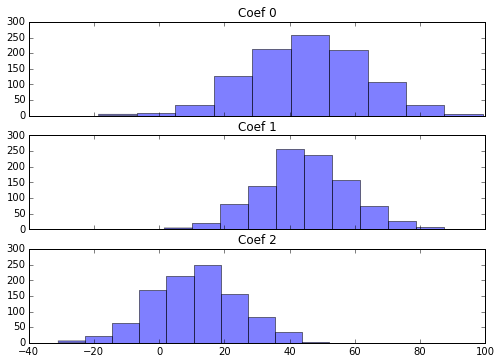

In [10]:
import numpy as np
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

def fit_2_regression(lr):
    n_bootstraps = 1000
    coefs = np.ones((n_bootstraps, 3))
    len_data = len(reg_data)
    subsample_size = np.int(0.75*len_data)
    subsample = lambda: np.random.choice(np.arange(0, len_data), size=subsample_size)

    for i in range(n_bootstraps):
        subsample_idx = subsample()
        subsample_X = reg_data[subsample_idx]
        subsample_y = reg_target[subsample_idx]
        lr.fit(subsample_X, subsample_y)
        coefs[i][0] = lr.coef_[0]
        coefs[i][1] = lr.coef_[1]
        coefs[i][2] = lr.coef_[2]
    %matplotlib inline
    import matplotlib.pyplot as plt
    f, axes = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(7, 5))
    f.tight_layout()

    for i, ax in enumerate(axes):
        ax.hist(coefs[:, i], color='b', alpha=.5)
        ax.set_title("Coef {}".format(i))
    return coefs

coefs = fit_2_regression(lr)

我们再用`Ridge`来拟合数据，对比结果：

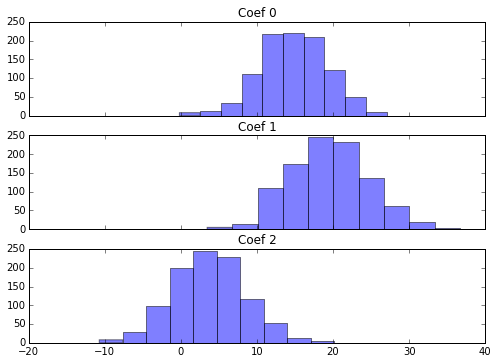

In [11]:
from sklearn.linear_model import Ridge
coefs_r = fit_2_regression(Ridge())

两个回归算法的结果看着好像差不多，其实不然。岭回归的相关系数更接近0。让我们看看两者相关系数的差异：

In [12]:
np.mean(coefs - coefs_r, axis=0)

array([ 30.54319761,  25.1726559 ,   7.40345307])

从均值上看，线性回归比岭回归的相关系数要更很多。均值显示的差异其实是线性回归的相关系数隐含的偏差。那么，岭回归究竟有什么好处呢？让我们再看看相关系数的方差：

In [13]:
np.var(coefs, axis=0)

array([ 302.16242654,  177.36842779,  179.33610289])

In [14]:
np.var(coefs_r, axis=0)

array([ 19.60727206,  25.4807605 ,  22.74202917])

岭回归的相关系数方差也会小很多。这就是机器学习里著名的偏差-方差均衡(Bias-Variance Trade-off)。下一个主题我们将介绍如何调整岭回归的参数正则化，那是偏差-方差均衡的核心内容。

##How it works...

介绍参数正则化之前，我们总结一下岭回归与线性回归的不同。前面介绍过，线性回归的目标是最小化
$
{\begin{Vmatrix}
\hat y - X \beta
\end{Vmatrix}}^2
$。

岭回归的目标是最小化
$
{\begin{Vmatrix}
\hat y - X \beta
\end{Vmatrix}}^2
+
{\begin{Vmatrix}
\Gamma X
\end{Vmatrix}}^2
$。

其中，$\Gamma$就是岭回归`Ridge`的`alpha`参数，指单位矩阵的倍数。上面的例子用的是默认值。我们可以看看岭回归参数：

In [16]:
Ridge()

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001)

岭回归相关系数的解是：
$$\beta = {(X^TX + \Gamma ^ T \Gamma)}^{-1}X \hat y$$

前面的一半和线性回归的相关系数的解是一样的，多了$\Gamma ^ T \Gamma)$一项。矩阵$A$的$AA^T$的结果是对称矩阵，且是半正定矩阵（对任意非0向量$x$，有$x^TAx \ge 0$）。相当于在线性回归的目标函数分母部分增加了一个很大的数。这样就把相关系数挤向0了。这样的解释比较粗糙，要深入了解，建议你看看SVD（矩阵奇异值分解）与岭回归的关系。